In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt


def load_fashion_mnist():
    """
    Loads Fashion MNIST dataset.
    
    Adapted from: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
    """
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'    
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

    with gzip.open(TRAIN_LABELS, 'rb') as tr_labels_file, gzip.open(TEST_LABELS, 'rb') as ts_labels_file:
        train_labels = np.frombuffer(tr_labels_file.read(), dtype=np.uint8, offset=8)
        test_labels = np.frombuffer(ts_labels_file.read(), dtype=np.uint8, offset=8)

    with gzip.open(TRAIN_IMAGES, 'rb') as tr_images_file, gzip.open(TEST_IMAGES, 'rb') as ts_images_file:
        train_images = np.frombuffer(tr_images_file.read(), dtype=np.uint8, offset=16).reshape(len(train_labels), 784)
        test_images = np.frombuffer(ts_images_file.read(), dtype=np.uint8, offset=16).reshape(len(test_labels), 784)

    return train_images, train_labels, test_images, test_labels

In [2]:
def pretty_print(image_example):
    """ Pretty prints a Fashion MNIST example.

    Parameters:
        image_example: a 1x784 numpy array corresponding to the features of
                       a single image.

    Returns:
        None.
    """
    print(np.array_str(image_example, precision=1, max_line_width=116))


In [3]:
def usage_example():
    """ Example of how to load and parse Fashion MNIST data. """
    
    train_images, train_labels, test_images, test_labels = load_fashion_mnist()

    # train_images is a 60,000 x 784 numpy matrix. There are 60k
    # rows in the matrix, each row corresponding to a single example.
    # There are 784 columns, each corresponding to the value of a
    # single pixel in the 28x28 image after it has been "flattened".
    print("Dimensions of training set feature matrix:", train_images.shape)

    # The labels for each example are maintained separately in train_labels.
    # This is a 60,000 x 1 numpy matrix, where each element is the label
    # for the corresponding training example.
    print("Dimensions of training set label matrix:", train_labels.shape)

    # Example of how to access a individual training example (in this case,
    # we pick an example at a random index). We could use print to output the
    # raw pixel values to the screen, but pretty_print formats the data in 
    # a nicer way: if you squint, you may be able to make out the contours of
    # the fashion article in the matrix data.
    EXAMPLE_INDEX = np.random.randint(60000)
    print("Features of training example at index {}:\n".format(EXAMPLE_INDEX))
    pretty_print(train_images[EXAMPLE_INDEX])

    # And here's the label that goes with that training example
    print("\nLabel of training example at index {}:".format(EXAMPLE_INDEX), train_labels[EXAMPLE_INDEX], '\n')

    # Finally, let's visualize the example we've picked as a 28x28 image
    plt.figure()
    plt.imshow(train_images[EXAMPLE_INDEX].reshape(28, 28))
    plt.show()
    
    # The test_images/test_labels are organized in the same way, but only contain 10k
    # examples. Don't touch this data until your model is frozen! Perform all
    # cross-validation, model selection, hyperparameter tuning etc. on the 60k
    # training set. Use the test set simply for reporting performance.


Dimensions of training set feature matrix: (60000, 784)
Dimensions of training set label matrix: (60000,)
Features of training example at index 5236:

[  0   0   0   0   0   0   0   0   0   0 116  93  90  87  91  91 118  65   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  43 255 242 246 247 252 252 254 239   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  97 244 180 187 198 223 215 232 255   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 121 242 189 196 206 227 210 229 255  15   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 124 237 190 194 211 227 211 223 255  21   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 137 237 188 197 218 216 203 214 255  35   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 148 231 186 202 237 202 214 216 255  36   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 144 234 187 235 254 2

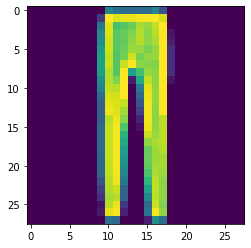

In [4]:
usage_example()

In [10]:
from sklearn.neighbors import KNeighborsClassifier
train_images, train_labels, test_images, test_labels = load_fashion_mnist()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_images, train_labels)
#try to make a pretty print of the images with the labels, tried to run the set but taking
#a long time to predict them
train_images
#print(neigh.predict(train_images))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)